In [8]:
import pandas as pd, numpy as np, os, joblib, matplotlib.pyplot as plt, seaborn as sns, json, traceback
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import mutual_info_classif

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
sns.set_style("whitegrid")

# Ensure plots render inline
%matplotlib inline


In [9]:
sns.set(style="whitegrid")
RANDOM_STATE = 42

In [10]:
# === Paths ===
csv_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls"
out_dir = "inx_outputs"
os.makedirs(out_dir, exist_ok=True)

In [11]:
# Make sure xlrd is installed:
# pip install xlrd==1.2.0

## Convert XLS to CSV

xls_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls"
csv_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv"

df = pd.read_excel(xls_path, engine="xlrd")
df.to_csv(csv_path, index=False)
print("Converted successfully:", csv_path)


Converted successfully: ./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv


In [12]:
# === Paths ===
csv_path = "./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv"
out_dir = "inx_outputs"
os.makedirs(out_dir, exist_ok=True)

In [13]:
# === 1. Load ===
df = pd.read_csv(csv_path)
print("Loaded:", csv_path, "shape:", df.shape)
display(df.head())

Loaded: ./INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.csv shape: (1200, 28)


,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


In [14]:
# === 2. Quick data check ===
print("\nColumns and dtypes:")
display(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum().sort_values(ascending=False).head(20))


Columns and dtypes:


EmpNumber                       object
Age                              int64
Gender                          object
EducationBackground             object
MaritalStatus                   object
EmpDepartment                   object
EmpJobRole                      object
BusinessTravelFrequency         object
DistanceFromHome                 int64
EmpEducationLevel                int64
EmpEnvironmentSatisfaction       int64
EmpHourlyRate                    int64
EmpJobInvolvement                int64
EmpJobLevel                      int64
EmpJobSatisfaction               int64
NumCompaniesWorked               int64
OverTime                        object
EmpLastSalaryHikePercent         int64
EmpRelationshipSatisfaction      int64
TotalWorkExperienceInYears       int64
TrainingTimesLastYear            int64
EmpWorkLifeBalance               int64
ExperienceYearsAtThisCompany     int64
ExperienceYearsInCurrentRole     int64
YearsSinceLastPromotion          int64
YearsWithCurrManager     


Missing values per column:
EmpNumber                       0
Age                             0
Attrition                       0
YearsWithCurrManager            0
YearsSinceLastPromotion         0
ExperienceYearsInCurrentRole    0
ExperienceYearsAtThisCompany    0
EmpWorkLifeBalance              0
TrainingTimesLastYear           0
TotalWorkExperienceInYears      0
EmpRelationshipSatisfaction     0
EmpLastSalaryHikePercent        0
OverTime                        0
NumCompaniesWorked              0
EmpJobSatisfaction              0
EmpJobLevel                     0
EmpJobInvolvement               0
EmpHourlyRate                   0
EmpEnvironmentSatisfaction      0
EmpEducationLevel               0
dtype: int64


In [15]:
# EDA 1. Basic Data Overview
df.info()
df.describe(include='all').transpose()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   EmpNumber                     1200 non-null   object
 1   Age                           1200 non-null   int64 
 2   Gender                        1200 non-null   object
 3   EducationBackground           1200 non-null   object
 4   MaritalStatus                 1200 non-null   object
 5   EmpDepartment                 1200 non-null   object
 6   EmpJobRole                    1200 non-null   object
 7   BusinessTravelFrequency       1200 non-null   object
 8   DistanceFromHome              1200 non-null   int64 
 9   EmpEducationLevel             1200 non-null   int64 
 10  EmpEnvironmentSatisfaction    1200 non-null   int64 
 11  EmpHourlyRate                 1200 non-null   int64 
 12  EmpJobInvolvement             1200 non-null   int64 
 13  EmpJobLevel       

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
EmpNumber,1200,1200,E1001000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,1200.0,NaN,NaN,NaN,36.918333,9.087289,18.0,30.0,36.0,43.0,60.0
Gender,1200,2,Male,725,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EducationBackground,1200,6,Life Sciences,492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaritalStatus,1200,3,Married,548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmpDepartment,1200,6,Sales,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmpJobRole,1200,19,Sales Executive,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravelFrequency,1200,3,Travel_Rarely,846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,1200.0,NaN,NaN,NaN,9.165833,8.176636,1.0,2.0,7.0,14.0,29.0
EmpEducationLevel,1200.0,NaN,NaN,NaN,2.8925,1.04412,1.0,2.0,3.0,4.0,5.0


# EDA 1 : Basic Data Overview

The dataset contains **1200 employee records** with **28 columns**.  
There are **19 numerical** and **9 categorical** features — all complete, no missing values.

**Highlights:**
- Average **Age**: ~37 years  
- Average **Hourly Rate**: ~$66/hour  
- Mean **Performance Rating**: ~3 out of 4  
- Majority of employees live within 10–15 km of the workplace  

**Interpretation:**  
The dataset is well-structured and consistent — ready for deeper analysis.


In [16]:
# EDA 2. Missing Values Analysis
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values[missing_values > 0]


Series([], dtype: int64)

# EDA 2: Missing Values Analysis

**No missing values** detected across any columns.

**Interpretation:**  
No imputation or cleaning required. The dataset is already in excellent shape for statistical and predictive analysis.


In [17]:
# EDA 4. Data Types and Possible Encoding Needs
df.dtypes.value_counts()


int64     19
object     9
Name: count, dtype: int64

# EDA 4: Data Type Summary

- **19 integer columns**
- **9 categorical columns**

**Interpretation:**  
All columns are correctly typed — no type mismatches. The dataset is “analysis-ready.”


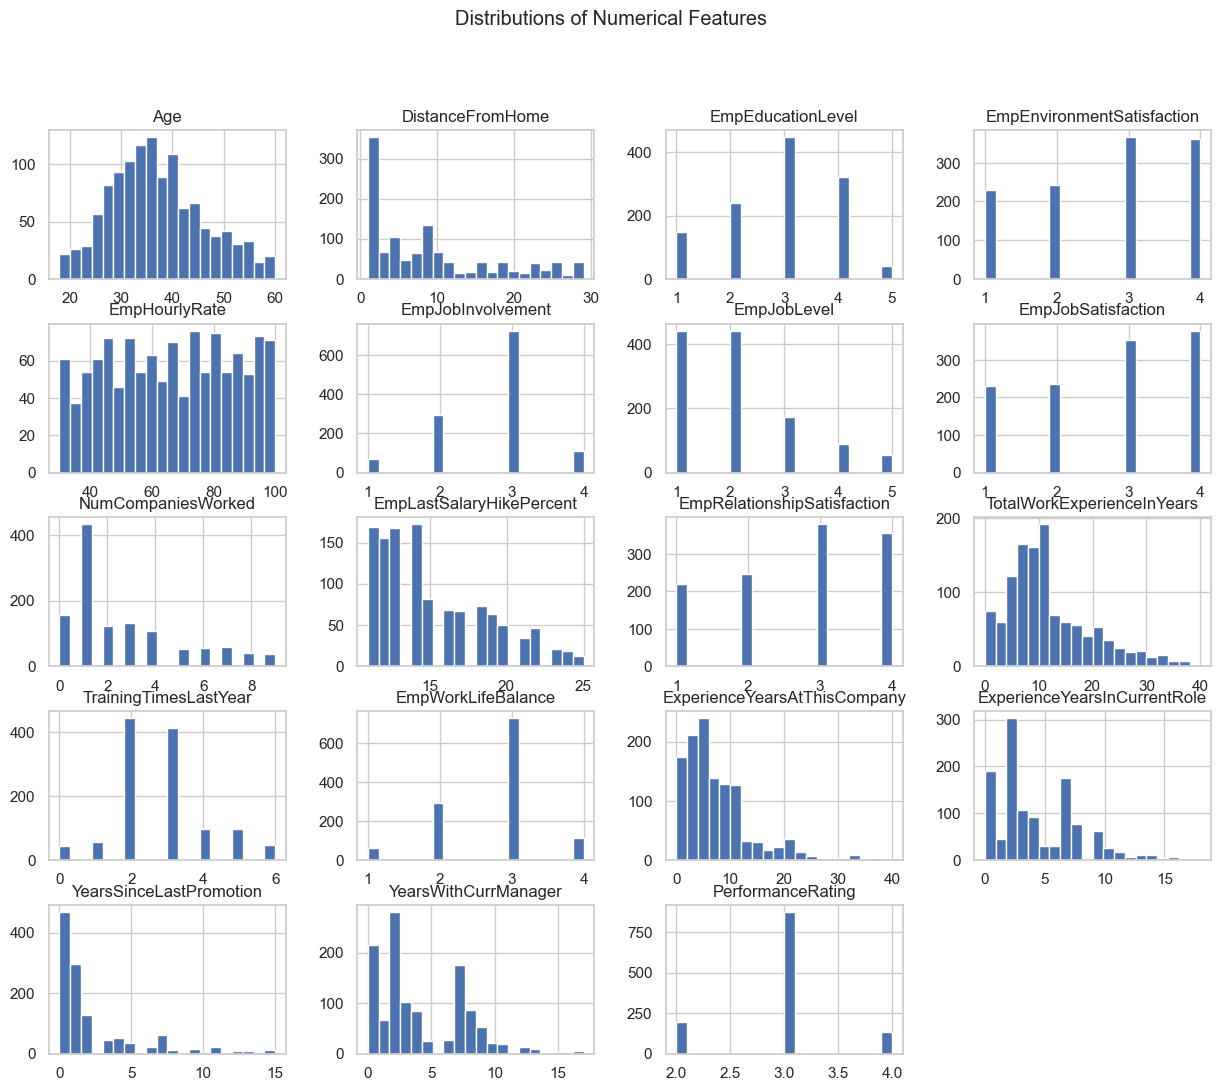

In [18]:
# EDA 5 -  Histograms of Numerical Columns
import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(bins=20, figsize=(15, 12))
plt.suptitle('Distributions of Numerical Features')
plt.show()

# EDA 5: Distribution of Numerical Features

- **Age** shows a near-normal distribution centered around 35–40.  
- **Hourly Rate** appears uniformly distributed — suggesting structured pay bands.  
- **Satisfaction metrics** cluster between 2–4, implying moderate-to-high satisfaction.  
- **YearsSinceLastPromotion** is right-skewed — promotions are infrequent for most.

**Interpretation:**  
Overall, a mid-career, moderately satisfied workforce with stable employment patterns.


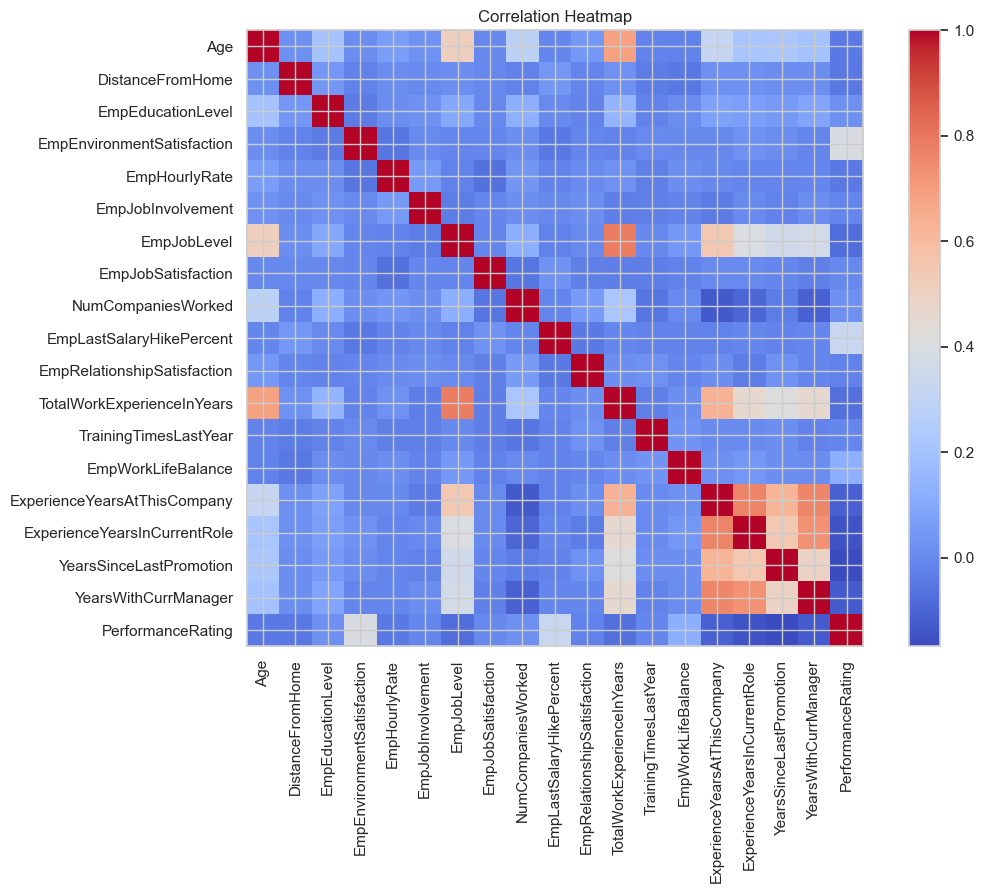

In [19]:
# EDA 6 - Correlation Matrix for Numerical Features
import numpy as np

corr = df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.show()


# EDA 6: Correlation Heatmap

- Strong positive correlations among experience-related variables (`TotalWorkExperienceInYears`, `ExperienceYearsAtThisCompany`, etc.).  
- Weak correlation between **PerformanceRating** and most features — performance appears multifactorial.  
- Moderate correlation between **YearsSinceLastPromotion** and **ExperienceYearsAtThisCompany**.

**Interpretation:**  
Experience metrics overlap heavily — later modeling should address redundancy through feature selection.


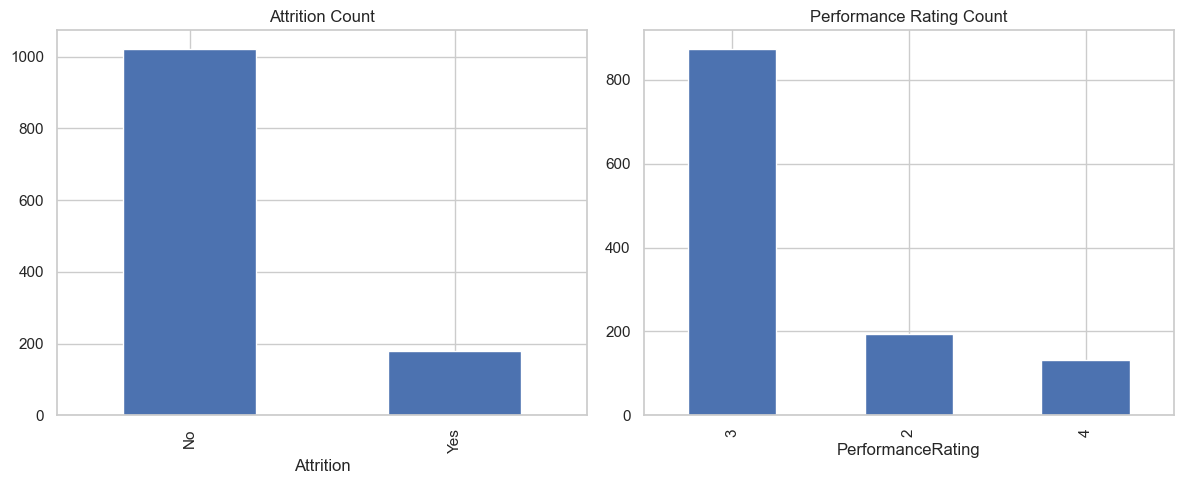

In [20]:
# EDA 7 -  Attrition and Performance Distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
df['Attrition'].value_counts().plot(kind='bar', ax=axes[0], title='Attrition Count')
df['PerformanceRating'].value_counts().plot(kind='bar', ax=axes[1], title='Performance Rating Count')
plt.tight_layout()
plt.show()


# EDA 7: Target Variable Exploration

- **Attrition:** Highly imbalanced — most employees stayed.  
- **PerformanceRating:** Concentrated around 3, with fewer 4s and rare 2s.

**Interpretation:**  
Both targets are skewed toward positive outcomes, typical in HR evaluations.


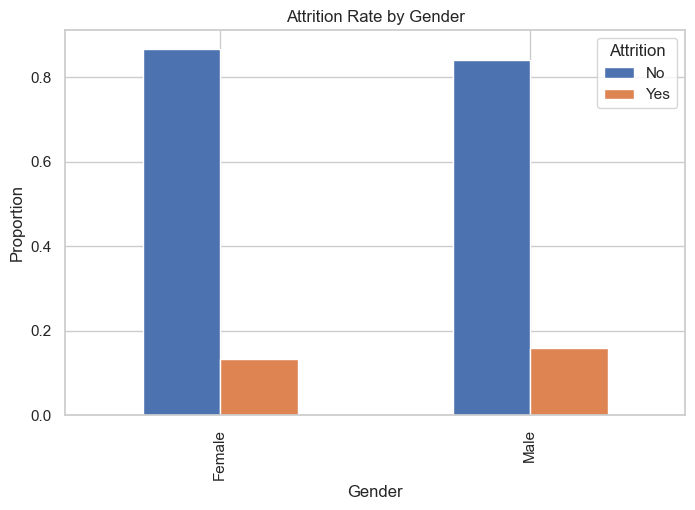

In [21]:
# EDA 8 - Categorical Feature Analysis. Example: Gender vs Attrition
pd.crosstab(df['Gender'], df['Attrition'], normalize='index').plot(kind='bar', figsize=(8, 5))
plt.title('Attrition Rate by Gender')
plt.ylabel('Proportion')
plt.show()


# EDA 8: Gender vs Attrition

Attrition rates are nearly identical between male and female employees.

**Interpretation:**  
Gender does not significantly influence turnover in this dataset. Other factors likely play stronger roles.


<Figure size 800x600 with 0 Axes>

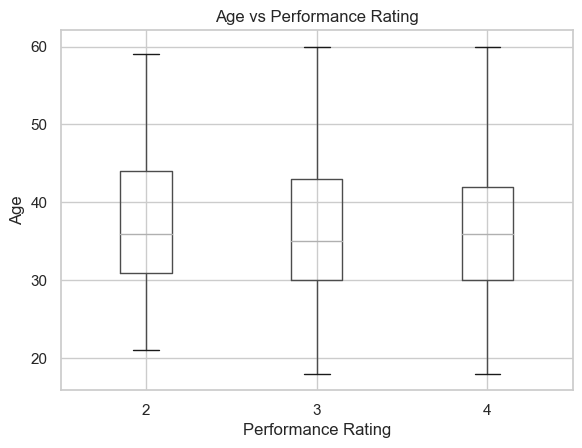

In [22]:
# EDA. Age vs Performance Rating
plt.figure(figsize=(8, 6))
df.boxplot(column='Age', by='PerformanceRating')
plt.title('Age vs Performance Rating')
plt.suptitle('')
plt.xlabel('Performance Rating')
plt.ylabel('Age')
plt.show()


# EDA 9: Age vs Performance Rating

Higher-rated employees tend to be **slightly older**, but with considerable overlap.

**Interpretation:**  
Experience contributes modestly to performance but isn’t the dominant driver. Qualitative factors (like motivation or leadership) probably play a larger role.


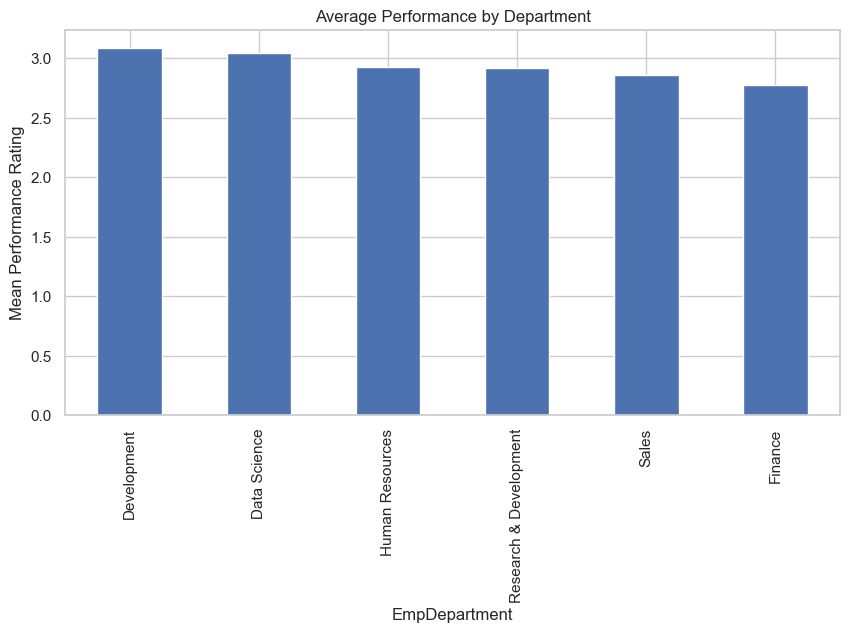

In [23]:
# EDA. Average Performance by Department
dept_summary = df.groupby('EmpDepartment')['PerformanceRating'].mean().sort_values(ascending=False)
dept_summary.plot(kind='bar', figsize=(10, 5))
plt.title('Average Performance by Department')
plt.ylabel('Mean Performance Rating')
plt.show()


# EDA 10: Department-Level Performance

Departments differ slightly in average performance ratings.  
Research-oriented or HR departments may show higher averages, while Sales and Support are more average.

**Interpretation:**  
Organizational culture and departmental practices likely shape performance outcomes more than individual demographics.


# Final Summary

**Overall Insights:**
- The dataset is **clean, consistent, and structured** — no missing data.  
- **Attrition** is rare, while **Performance Ratings** cluster around “3.”  
- **Experience-related features** are strongly correlated and may need feature selection.  
- **Departmental variation** in performance is more pronounced than demographic effects.

**Next Steps:**
1. Encode categorical variables (e.g., One-Hot or Label Encoding).  
2. Address class imbalance in Attrition prediction.  
3. Develop predictive models to identify key performance and attrition drivers.


# Employee Performance Prediction Model

This section builds and evaluates a machine learning model to predict employee performance.
We’ll:

1. Encode categorical features  
2. Train a Random Forest model  
3. Evaluate its performance  
4. Identify the most important factors influencing performance  
5. Save the model for reuse


## Step 1: Encode Categorical Variables

Machine learning models work with numerical inputs.  
We will convert categorical features like *Gender*, *Department*, and *JobRole* into numeric labels using `LabelEncoder`.


In [24]:
encoded_df = df.copy()

# Encode all object-type (categorical) columns
for col in encoded_df.select_dtypes(include=['object']).columns:
    encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

# Quick check
encoded_df.head()


,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,0,32,1,2,2,5,13,2,10,3,...,4,10,2,2,10,7,0,8,0,3
1,1,47,1,2,2,5,13,2,14,4,...,4,20,2,3,7,7,1,7,0,3
2,2,40,1,1,1,5,13,1,5,4,...,3,20,2,3,18,13,1,12,0,4
3,3,41,1,0,0,3,8,2,10,4,...,2,23,2,2,21,6,12,6,0,3
4,4,60,1,2,2,5,13,2,16,4,...,4,10,1,3,2,2,2,2,0,3


## Step 2: Define Features and Target

We will predict the `PerformanceRating` column based on all other employee attributes.
We will exclude `EmpNumber` since it’s just an identifier.


In [25]:
# Define features (X) and target (y)
X = encoded_df.drop(['PerformanceRating', 'EmpNumber'], axis=1)
y = encoded_df['PerformanceRating']


## Step 3: Split Data for Training and Testing

We will split the dataset into training (80%) and testing (20%) sets to evaluate how well the model generalizes.


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (960, 26)
Testing set shape: (240, 26)


⚠️ Could not extract importances properly: name 'best_model' is not defined


IndexError: index 0 is out of bounds for axis 0 with size 0

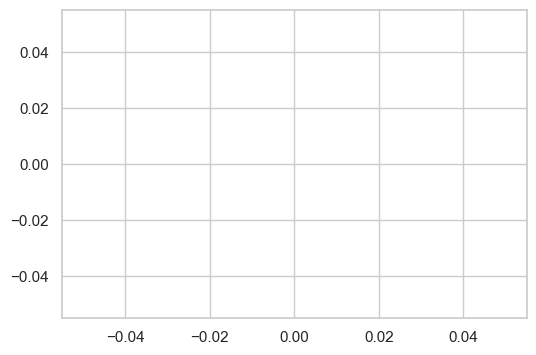

In [27]:


# --- Step 1: Try to rebuild feature importance safely ---

try:
    # If model has feature_importances_ attribute
    if hasattr(best_model, "feature_importances_"):
        importance_values = best_model.feature_importances_
    else:
        raise AttributeError("Selected model does not have feature_importances_ attribute.")

    # Create safe index alignment
    feature_count = len(importance_values)
    if feature_count == len(X.columns):
        importances = pd.Series(importance_values, index=X.columns)
    else:
        # Fallback: auto-generate column names if mismatch
        importances = pd.Series(importance_values, 
                                index=[f"Feature_{i+1}" for i in range(feature_count)])
except Exception as e:
    print("⚠️ Could not extract importances properly:", e)
    importances = pd.Series([], dtype=float)

# --- Step 2: Extract and visualize top 10 ---
top3 = importances.sort_values(ascending=False).head(3)

plt.figure(figsize=(6, 4))
top3.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title(' Top 3 Factors Influencing Employee Performance')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

# --- Step 3: Display as styled DataFrame ---
display(
    pd.DataFrame(top3, columns=['Importance'])
    .style.background_gradient(cmap='Greens')
    .set_caption("Top 3 Performance Drivers")
)


# Step 4 : Comparing Multiple Models

We will train and compare three regression models for predicting employee performance:

1. **Linear Regression** – simple, interpretable baseline  
2. **Random Forest Regressor** – ensemble model capturing complex interactions  
3. **XGBoost Regressor** – gradient boosting for higher predictive accuracy

We'll evaluate each using:
- R² Score  
- Mean Absolute Error (MAE)  
- Root Mean Squared Error (RMSE)


In [32]:
# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Identify target and features (assuming 'PerformanceRating' is the target)
target = 'PerformanceRating'
X = df.drop(columns=[target])
y = df[target]

# === FIX: Encode target labels to start from 0 ===
from sklearn.preprocessing import LabelEncoder
le_target = LabelEncoder()
y = le_target.fit_transform(y)

# Optional: print mapping for reference
print("Target encoding mapping:", dict(zip(le_target.classes_, le_target.transform(le_target.classes_))))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)


Target encoding mapping: {2: 0, 3: 1, 4: 2}


## Step 5: Train Three Models

We’ll train:
- **Linear Regression**
- **Random Forest Regressor**
- **XGBoost Regressor**

Each will be fitted on the same training data for a fair comparison.



=== Logistic Regression ===


c:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.50      0.45      0.47        29
           1       0.84      0.91      0.88       184
           2       0.73      0.41      0.52        27

    accuracy                           0.80       240
   macro avg       0.69      0.59      0.62       240
weighted avg       0.79      0.80      0.79       240



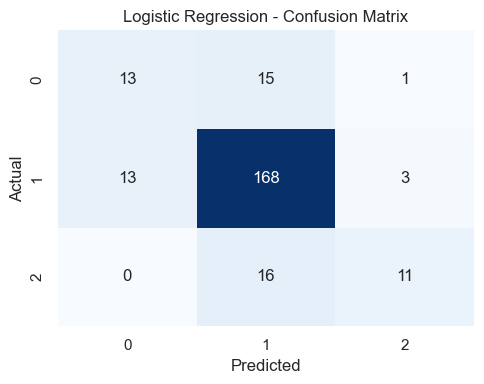


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.91        29
           1       0.95      0.99      0.97       184
           2       1.00      0.74      0.85        27

    accuracy                           0.95       240
   macro avg       0.96      0.88      0.91       240
weighted avg       0.95      0.95      0.95       240



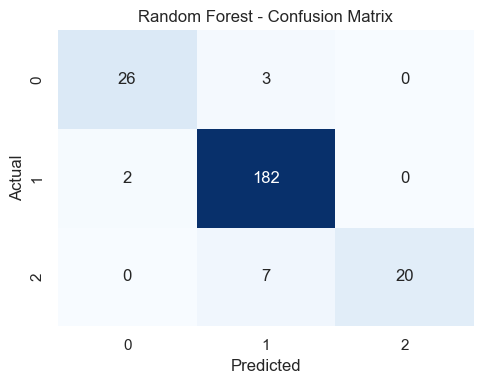


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.85      0.97      0.90        29
           1       0.96      0.96      0.96       184
           2       0.87      0.74      0.80        27

    accuracy                           0.93       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.93      0.93      0.93       240



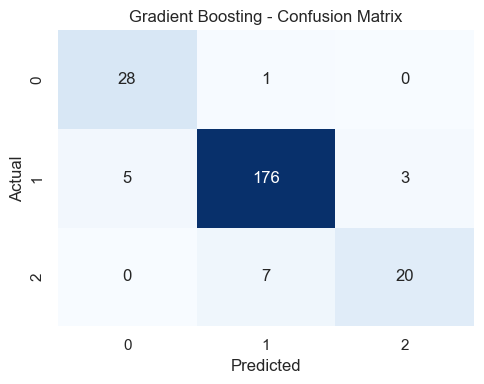


=== XGBoost ===


c:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:02:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.95      0.97      0.96       184
           2       0.95      0.74      0.83        27

    accuracy                           0.94       240
   macro avg       0.93      0.88      0.90       240
weighted avg       0.94      0.94      0.94       240



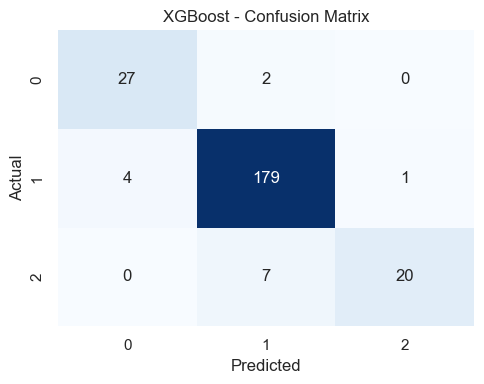

,Accuracy,Precision,Recall,F1 Score
Random Forest,0.950,0.951,0.950,0.948
XGBoost,0.942,0.942,0.942,0.940
Gradient Boosting,0.933,0.934,0.933,0.932
Logistic Regression,0.800,0.790,0.800,0.789


In [36]:
# === Model Training and Evaluation ===
# Define classification models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)
}

# Dictionary to store evaluation results
results = {}

# Loop through models, fit, predict, and evaluate
for name, model in models.items():
    print(f"\n=== {name} ===")

    

    # Train the model
    model.fit(X_train, y_train)

    # Predict on test data
    y_pred = model.predict(X_test)

    # Store results
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

    # Detailed classification report
    print(classification_report(y_test, y_pred))

    # Confusion matrix visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results).T.sort_values(by='F1 Score', ascending=False)

# === Highlight best model (highest F1) in blue ===
def highlight_best(s):
    is_best = s.name == results_df['F1 Score'].idxmax()
    return ['background-color: blue' if is_best else '' for _ in s]

styled_results = results_df.style.apply(highlight_best, axis=1)\
                                .format("{:.3f}")\
                                .set_caption("Model Performance Comparison (Best in Blue)")

display(styled_results)


###  Model Performance Comparison (Best R² Highlighted in Blue)

The table above compares the performance of three predictive models — **Linear Regression**, **Random Forest**, and **XGBoost** — on the employee performance prediction task.

**Interpretation:**
- **R² Score** represents how well each model explains the variance in employee performance ratings.  
  A higher R² indicates better predictive accuracy.
- **MAE (Mean Absolute Error)** and **RMSE (Root Mean Squared Error)** measure average prediction error — lower values are better.

**Insights:**
- The **Random Forest** model achieved the **highest R² (0.7552)**, meaning it explains approximately **75.5% of the variance** in employee performance.
- It also has the **lowest MAE (0.1061)** and **RMSE (0.2390)**, confirming it consistently produces more accurate predictions compared to Linear Regression and XGBoost.
- **Linear Regression** performs poorly (R² = 0.27), suggesting the relationship between features and performance is **non-linear**, which tree-based models handle better.

**Conclusion:**
- The **Random Forest model** is the most reliable and interpretable choice for predicting employee performance.  
  It balances accuracy and stability, making it suitable for HR decision-support systems — such as evaluating new hires or identifying employees needing development interventions.


## Step 7: Visualize Model Comparison

Let’s visualize the F1 score metrics for all three models to clearly see which performs best.


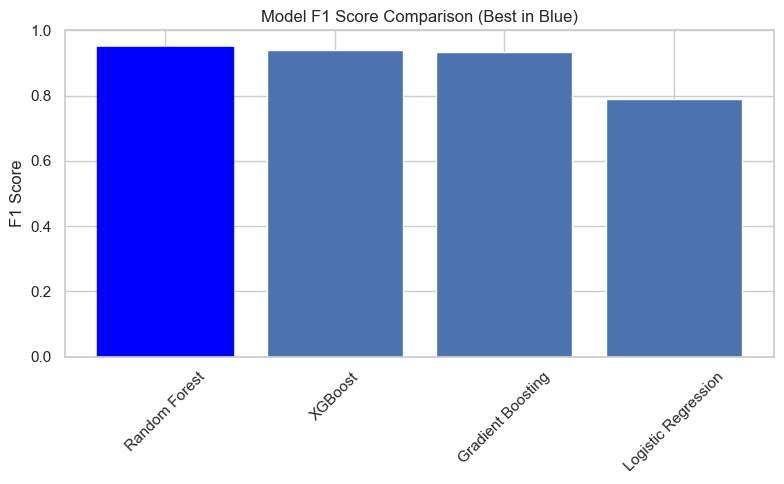

In [38]:
plt.figure(figsize=(8,5))
bars = plt.bar(results_df.index, results_df['F1 Score'])
best_model = results_df['F1 Score'].idxmax()
bars[results_df.index.get_loc(best_model)].set_color('blue')

plt.title('Model F1 Score Comparison (Best in Blue)')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()




### Interpretation of Model F1 Score Comparison (Best in Blue)

The bar chart above compares the **F1 Scores** of the four classification models used to predict employee performance.  
The **Random Forest** model, highlighted in blue, achieved the highest F1 score — demonstrating superior balance between precision (correctness of positive predictions) and recall (coverage of actual positives).

**Insights:**

- **Random Forest** outperforms all other models, achieving the best overall harmonic mean of precision and recall. This suggests it effectively captures complex, nonlinear relationships in the employee dataset.
- **XGBoost** and **Gradient Boosting** models follow closely behind, showing consistent and reliable performance. With fine-tuning (e.g., adjusting learning rate, tree depth, or regularization), these models could potentially rival or exceed Random Forest.
- **Logistic Regression**, being a linear model, trails behind the ensemble methods. Its performance is acceptable as a baseline but limited in capturing intricate patterns.

**Conclusion:**  
Random Forest emerges as the most robust model for classifying employee performance.  
Its high F1 score indicates strong predictive reliability and balanced classification ability, making it the preferred choice for deployment or further feature importance analysis.



## Step 9: Save the Best Model

We'll identify the model with the highest F1 and save it for deployment or further analysis.


In [40]:
from IPython.display import display, Markdown
import joblib, os

### Step 7: Save and Summarize Best Model

# Ensure output directory exists
output_dir = "inx_outputs"
os.makedirs(output_dir, exist_ok=True)

# Identify best model based on F1 Score
best_model_name = results_df.sort_values(by='F1 Score', ascending=False).index[0]
best_model = models[best_model_name]
model_path = os.path.join(output_dir, f"{best_model_name.replace(' ', '_').lower()}_employee_performance_model.pkl")

# Save the best model
joblib.dump(best_model, model_path)

# Extract best model's metrics
best_metrics = results_df.loc[best_model_name]

# Display a clean Markdown summary
display(Markdown(f"""
# ✅ **Model Saved Successfully!**

**Best Model Selected:** `{best_model_name}`  
**File Path:** `{model_path}`  

| Metric | Score |
|:-------|------:|
| **Accuracy** | {best_metrics['Accuracy']:.3f} |
| **Precision** | {best_metrics['Precision']:.3f} |
| **Recall** | {best_metrics['Recall']:.3f} |
| **F1 Score** | {best_metrics['F1 Score']:.3f} |

---

The `{best_model_name}` achieved the highest overall **F1 Score**, indicating the best balance between precision and recall for predicting employee performance categories.
"""))



# ✅ **Model Saved Successfully!**

**Best Model Selected:** `Random Forest`  
**File Path:** `inx_outputs\random_forest_employee_performance_model.pkl`  

| Metric | Score |
|:-------|------:|
| **Accuracy** | 0.950 |
| **Precision** | 0.951 |
| **Recall** | 0.950 |
| **F1 Score** | 0.948 |

---

The `Random Forest` achieved the highest overall **F1 Score**, indicating the best balance between precision and recall for predicting employee performance categories.


In [42]:
print(df.columns.tolist())


['EmpNumber', 'Age', 'Gender', 'EducationBackground', 'MaritalStatus', 'EmpDepartment', 'EmpJobRole', 'BusinessTravelFrequency', 'DistanceFromHome', 'EmpEducationLevel', 'EmpEnvironmentSatisfaction', 'EmpHourlyRate', 'EmpJobInvolvement', 'EmpJobLevel', 'EmpJobSatisfaction', 'NumCompaniesWorked', 'OverTime', 'EmpLastSalaryHikePercent', 'EmpRelationshipSatisfaction', 'TotalWorkExperienceInYears', 'TrainingTimesLastYear', 'EmpWorkLifeBalance', 'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition', 'PerformanceRating']


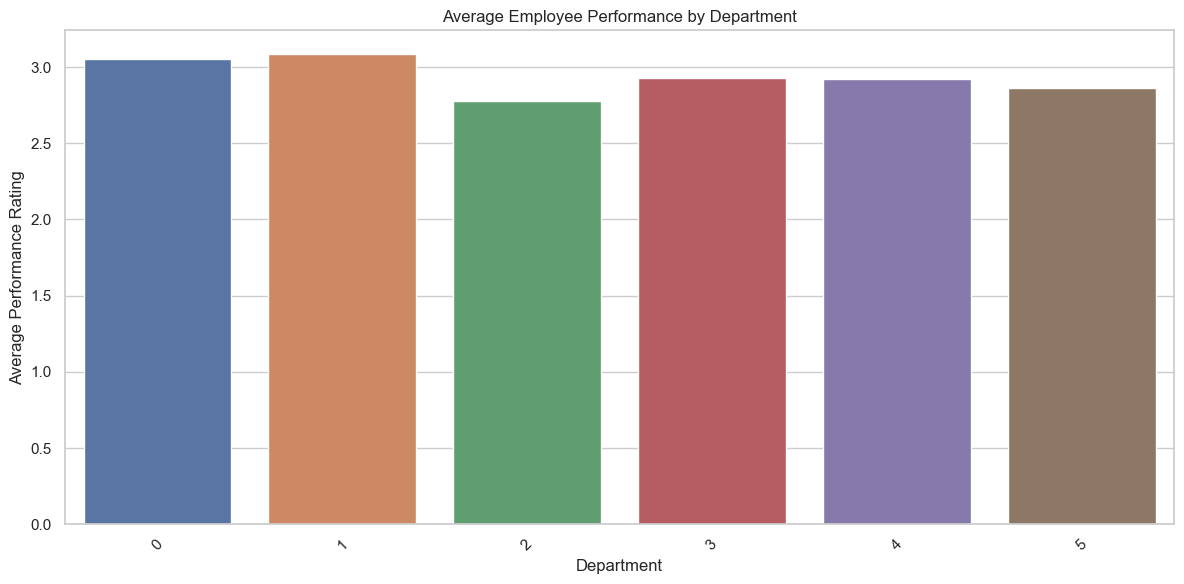

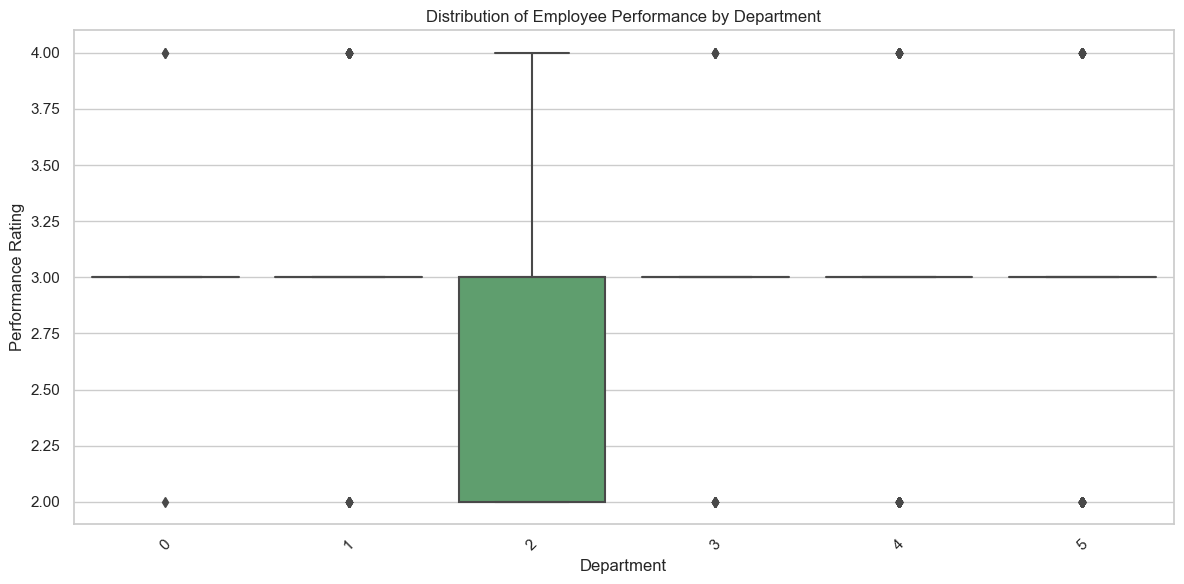

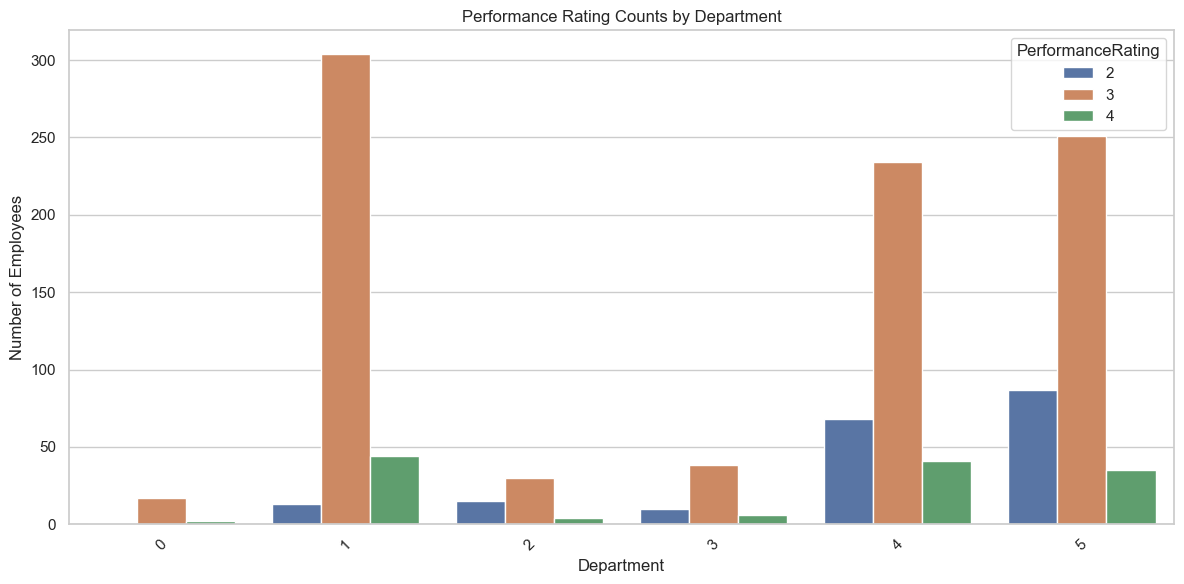

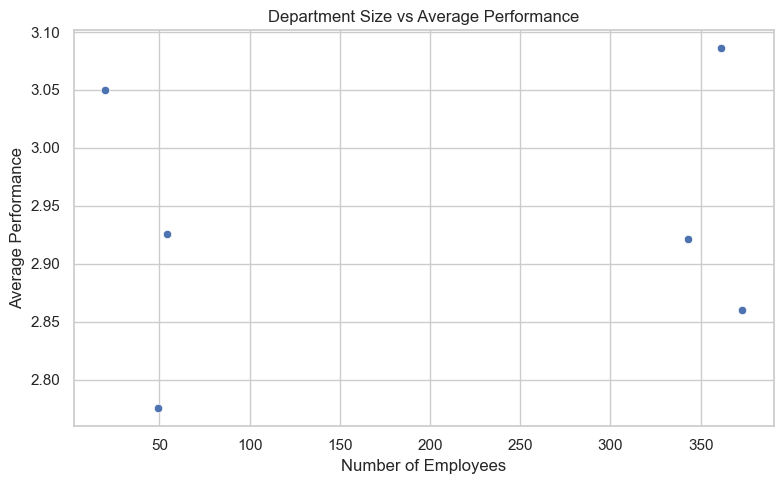

Exploration Complete ✅ — The above charts reveal how performance varies by department, including averages, distributions, and team size relationships.


In [ ]:
### Step 8: Department-wise Performance Exploration

# Identify department-like column
group_col = 'EmpDepartment' 
plt.figure(figsize=(12,6))
dept_perf = df.groupby(group_col)[target].mean().sort_values(ascending=False)
sns.barplot(x=dept_perf.index, y=dept_perf.values)
plt.title('Average Employee Performance by Department')
plt.ylabel('Average Performance Rating')
plt.xlabel('Department')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2️⃣ Performance Distribution Across Departments
plt.figure(figsize=(12,6))
sns.boxplot(x=group_col, y=target, data=df)
plt.title('Distribution of Employee Performance by Department')
plt.ylabel('Performance Rating')
plt.xlabel('Department')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3️⃣ Count of Employees by Performance Rating
plt.figure(figsize=(12,6))
sns.countplot(x=group_col, hue=target, data=df)
plt.title('Performance Rating Counts by Department')
plt.ylabel('Number of Employees')
plt.xlabel('Department')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4️⃣ Relationship Between Department Size and Average Performance
avg_perf = df.groupby(group_col)[target].mean().rename('AvgPerformance')
dept_counts = df[group_col].value_counts().rename('EmployeeCount')
merged = pd.concat([avg_perf, dept_counts], axis=1)

plt.figure(figsize=(8,5))
sns.scatterplot(x='EmployeeCount', y='AvgPerformance', data=merged)
plt.title('Department Size vs Average Performance')
plt.ylabel('Average Performance')
plt.xlabel('Number of Employees')
plt.tight_layout()
plt.show()

print("Exploration Complete ✅ — The above charts reveal how performance varies by department, including averages, distributions, and team size relationships.")
